In [1]:
import gurobipy as gb
import numpy as np

from gurobipy import GRB
from utils import file_reader as fr
from utils import data_generator as dg
from utils import data_visualizer as dv


# First MSSP-PD(ABP) example

In MSPP-PD we want to minimize not only distances, but also the path conflict between different agents and since "path conflict" can take on different nuances we can define different versions of the MSPP-PD.  

For example it can be assessed as it pertains to agents' paths when they utilize the same arcs, the same nodes, or both. Furthermore also the degree of penalty assessed for a given (node or arc) conflict may vary. Conflic may be of concern:

- simply for occurring (binary metric);
- for occurring in relation to the number of agents for a given path conflict (linear metric), or;
- for occurring in relation to the number of potential interactions between agents for a given conflict (quadratic metric).  

Each possible combination will result in a different version of the MSPP-PD.

The one we will focus on this notebook is the one that penalize agent's path conflict on the network arcs in a binary fashion (arc binary penalties (__ABP__)). This means that for instance, if $2,...,n$ agents use arc $(i,j)$ on their respective sources-terminus paths, an arc binary penalty equal to 1 will be incurred.  

In the following we'll formulate and solve a MSPP-PD(ABP)


## Read data

In this section we read the file containing the netwoork instance that we'll use to solve the MSPP.  
The instance is the same as in the case of the MSPP


In [2]:
synthetic_5x5_df = fr.read_networks_csv("data/d_it_ij_5x5_1it.csv",
                                        along="cols")

# show some arcs with related weights of the network
synthetic_5x5_df.T.head()


it1
0 5  3.0
  6  1.0
1 5  1.0
  6  1.0
  7  1.0

## Manage data

In this section we define the variables that we'll use to formulate and solve the MSPP-PD(ABP) problem starting from the dataframe containing the network instance


In [3]:
# nodes in the network
nodes = dg.get_nodes(synthetic_5x5_df)
network_shape = (5, 5)
nodes_grid = np.array(nodes).reshape(network_shape).T


# weighted arcs in the network
# the weight of each arc represents the ditance between 2 nodes
w_arcs = [dg.WArc(i, j, synthetic_5x5_df.loc["it1", (i, j)], idx)
          for idx, (i, j) in enumerate(synthetic_5x5_df.columns)]


# agets that has to be routed
agents_sources = [0, 2, 3, 4]
agents_terminus = [20, 22, 23, 24]
agents_idxs = [0, 1, 2, 3]
agents = [dg.Agent(s, t, idx) for s, t, idx in zip(
    agents_sources, agents_terminus, agents_idxs)]


## Problem formulation and solution

In this section we formulate and solve the MSPP-PD(ABP) problem using Gurobi.  
The formulations follows the one reported in section 2.3 of the paper


Create the problem

In [4]:
MSPP_PD_ABP_pb = gb.Model("First MSPP_PD_ABP_pb")
# MSPP_PD_ABP_pb.setParam("OutputFlag", 0)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-10


Define decision variables

In [5]:
X_var_shape = len(w_arcs), len(agents)
Psi_var_shape = len(w_arcs)

X = MSPP_PD_ABP_pb.addMVar(X_var_shape,
                           vtype=GRB.BINARY,  # 5) Binary constraints
                           name="X")

Psi = MSPP_PD_ABP_pb.addMVar(Psi_var_shape,
                             vtype=GRB.BINARY,  # 8) Binary constraints
                             name="Psi")


Define the 2 objective functions:
- one that penalize solutions that makes agents travel higher distances
- one that penalize solutions that makes agents traverse the same arcs


In [6]:
# 1:3, 6) Objective functions
distance_obj = gb.quicksum(
    arc.w * X[arc.idx, agent.idx]
    for arc in w_arcs for agent in agents
)
penalty_obj = gb.quicksum(
    Psi[arc.idx] for arc in w_arcs
)

# as result objective will be: f(X, Psi) = 0.5*distance_obj(X) + 0.5*penalty_obj(Psi)
MSPP_PD_ABP_pb.setObjectiveN(distance_obj, index=0, weight=0.5,
                             name="Distance")
MSPP_PD_ABP_pb.setObjectiveN(penalty_obj, index=1, weight=0.5,
                             name="Penalty")


Add constraints


In [7]:
# 4) Flow constraints

def compute_flow(X, node, w_arcs, agent):
    """Compute the flow in a node of a network for a given agent that traverse it

    Args:
        X (gb.MVar): X decision variables of a MSPP or MSPP-PD problem
        node (int): the node on which compute the flow
        w_arcs (list): list of WArc that compose the network
        agent (Agent): the agent for which to calculate the flow

    Returns:
        gb.MLinExpr: linear matrix expression that represent the flow for the agent in the node
    """

    flow_out = gb.quicksum(
        X[arc.idx, agent.idx]
        for arc in w_arcs if arc.i == node
    )
    flow_in = gb.quicksum(
        X[arc.idx, agent.idx]
        for arc in w_arcs if arc.j == node
    )
    return flow_out - flow_in


for agent in agents:
    for node in nodes:
        if node == agent.source:
            MSPP_PD_ABP_pb.addConstr(compute_flow(X, node, w_arcs, agent) == 1)
        elif node == agent.terminus:
            MSPP_PD_ABP_pb.addConstr(
                compute_flow(X, node, w_arcs, agent) == -1)
        else:
            MSPP_PD_ABP_pb.addConstr(compute_flow(X, node, w_arcs, agent) == 0)


In [8]:
# 7) Binary penalization constraints

for arc in w_arcs:
    MSPP_PD_ABP_pb.addConstr(
        1/len(agents) *
        (gb.quicksum(X[arc.idx, agent.idx] for agent in agents) - 1)
        <= Psi[arc.idx]
    )


Solve the problem


In [9]:
# min( f(X, Psi) )
MSPP_PD_ABP_pb.optimize()


Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 152 rows, 260 columns and 676 nonzeros
Model fingerprint: 0x3a72c5db
Variable types: 0 continuous, 260 integer (260 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives (1 combined) ...
---------------------------------------------------------------------------
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 (weighted) ...
---------------------------------------------------------------------------

Optimize a model with 152 rows, 260 

## Report results

In this section we report the results that we've obtained


In [10]:
print("Result of the optimization is:")
if MSPP_PD_ABP_pb.Status == 2:
    print("optimal")
elif MSPP_PD_ABP_pb.Status == 3:
    print("infeasible")
elif MSPP_PD_ABP_pb.Status == 5:
    print("unbounded")
else:
    print("Some other return status")


Result of the optimization is:
optimal


In [11]:
n_objectives = MSPP_PD_ABP_pb.NumObj

print("Optimal solution is such that:")
obj_tot_value = 0
for obj_n in range(n_objectives):
    MSPP_PD_ABP_pb.params.ObjNumber = obj_n
    obj_tot_value = obj_tot_value + MSPP_PD_ABP_pb.ObjNWeight*MSPP_PD_ABP_pb.ObjNVal
    print(f" {MSPP_PD_ABP_pb.ObjNName}={MSPP_PD_ABP_pb.ObjNVal} ", end="|")
print(f" Weighted Total={obj_tot_value}")


Optimal solution is such that:
 Distance=16.0 | Penalty=1.0 | Weighted Total=8.5


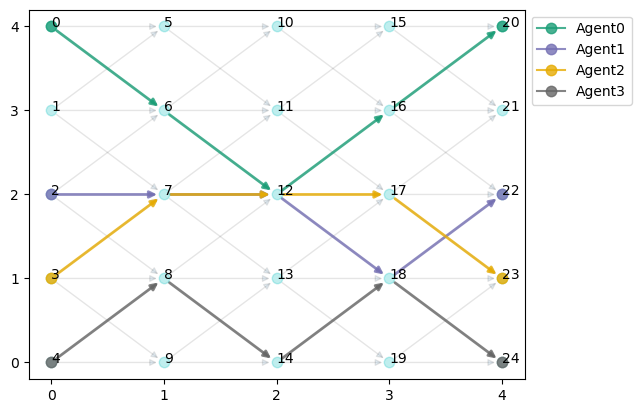

In [12]:
dv.plot_solution(X.x, nodes_grid, w_arcs, agents)


## About different solutions

We can notice that the solution reported in the article (Fig. 6) is diferent from what we found.  
However our solution is still an optimal solution since it has the same total distance and penalty (therefore same total objective value) of the paper's solution. We'll show this in the following...

Useful function to retrieve the index of an arc from its starting and ending nodes

In [13]:
def arc_ij_to_idx(w_arcs_list, i, j):
    """Gets the arc index of the WArc which has i as starting node and j as ending node

    Args:
        w_arcs_list (list): List of WArcs where to look for the desired arc index
        i (int): starting node of the desired arc
        j (int): ending node of the desired arc

    Returns:
        int: the index of the desired WArc or None if the desired arc is not present in w_arcs_list
    """

    return next((arc.idx for arc in w_arcs_list if arc.i == i and arc.j == j), None)


Force the solution to be the same as in Fig. 6

In [14]:
# Agent 0 path
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 0, 6), 0] == 1)
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 6, 12), 0] == 1)
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 12, 16), 0] == 1)
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 16, 20), 0] == 1)

# Agent 1 path
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 2, 7), 1] == 1)
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 7, 12), 1] == 1)
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 12, 17), 1] == 1)
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 17, 22), 1] == 1)

# Agent 2 path
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 3, 7), 2] == 1)
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 7, 12), 2] == 1)
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 12, 18), 2] == 1)
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 18, 23), 2] == 1)

# Agent 3 path
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 4, 8), 3] == 1)
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 8, 14), 3] == 1)
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 14, 18), 3] == 1)
MSPP_PD_ABP_pb.addConstr(X[arc_ij_to_idx(w_arcs, 18, 24), 3] == 1)


<MConstr () *awaiting model update*>

Solve the problem


In [15]:
# Discard previous solutions
MSPP_PD_ABP_pb.reset()

MSPP_PD_ABP_pb.optimize()


Discarded solution information
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 168 rows, 260 columns and 692 nonzeros
Model fingerprint: 0xdd58228e
Variable types: 0 continuous, 260 integer (260 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives (1 combined) ...
---------------------------------------------------------------------------
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 (weighted) ...
---------------------------------------------------------------------------

Optim

Report results


In [16]:
print("Result of the optimization is:")
if MSPP_PD_ABP_pb.Status == 2:
    print("optimal")
elif MSPP_PD_ABP_pb.Status == 3:
    print("infeasible")
elif MSPP_PD_ABP_pb.Status == 5:
    print("unbounded")
else:
    print("Some other return status")


Result of the optimization is:
optimal


In [17]:
n_objectives = MSPP_PD_ABP_pb.NumObj

print("Optimal solution is such that:")
obj_tot_value = 0
for obj_n in range(n_objectives):
    MSPP_PD_ABP_pb.params.ObjNumber = obj_n
    obj_tot_value = obj_tot_value + MSPP_PD_ABP_pb.ObjNWeight*MSPP_PD_ABP_pb.ObjNVal
    print(f" {MSPP_PD_ABP_pb.ObjNName}={MSPP_PD_ABP_pb.ObjNVal} ", end="|")
print(f" Weighted Total={obj_tot_value}")


Optimal solution is such that:
 Distance=16.0 | Penalty=1.0 | Weighted Total=8.5


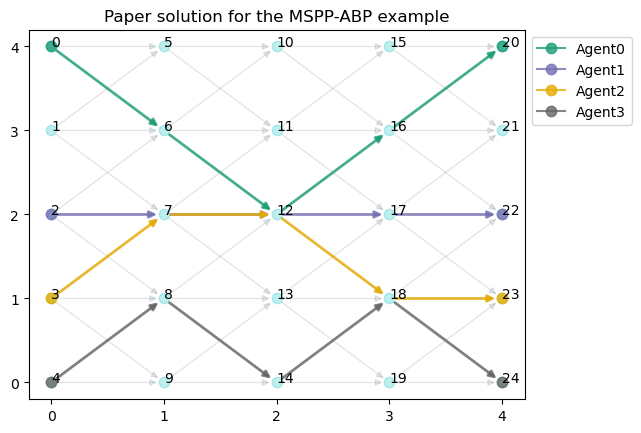

In [18]:
dv.plot_solution(X.x, nodes_grid, w_arcs, agents, title="Paper solution for the MSPP-ABP example")


So we can state that the solution to the MSPP-PD(ABP) for the considered network is not unique since the solution found by us and the one reported in the paper have the same objective value
